In [1]:
import os
import re

#from nltk.tokenize import word_tokenize

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.fixes import signature
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score

import operator
import matplotlib.pyplot as plt

import numpy as np
from numpy import array

from keras import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.layers import Embedding, Flatten
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

Using TensorFlow backend.


In [2]:
def plot_learning_curve(estimator, x, y, ylim=None, **kwargs):
    
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, **kwargs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r"
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g"
    )
    
    plt.plot(
        train_sizes, train_scores_mean, 'o-',
        color="r",
        label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, 'o-',
        color="g",
        label="Validation score"
    )

    plt.legend(loc="best")
    
    plt.show()

In [3]:
np.random.seed(7)

In [4]:
directory_path = r"C:\Users\User\Downloads\lingspam_public\lingspam_public"
directory_path2= r"C:\Users\User\Downloads\lingspam_public\extra_data"

In [5]:
ham, spam = [], []
root = directory_path
for dirpath, _, filenames in os.walk(root):
    for filename in filenames:
        with open(os.path.join(dirpath, filename), encoding="utf8") as file:
            message = file.read()
        if filename.startswith("spm"):
            spam.append(message)
        else:
            ham.append(message)
print("Ham: {}, Spam: {}".format(len(ham), len(spam)))

Ham: 9649, Spam: 1924


In [6]:
for folder in os.listdir(directory_path2):
    for file in os.listdir(os.path.join(directory_path2, folder)):
        with open(os.path.join(directory_path2, folder, file), encoding='latin1') as f:
            message = f.read()
            if folder == "spam":
                spam.append(message)
            elif folder == "ham":
                message = f.read()
                ham.append(message)
print("Final ham: {}, Final spam: {}".format(len(ham), len(spam)))

Final ham: 9749, Final spam: 2024


In [7]:
x = ham + spam
y = [0] * len(ham) + [1] * len(spam)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)

In [8]:
# Preprocessing our data
# DefaultTfidfVectorizer = partial(
#     TfidfVectorizer,
#     input="content", analyzer="word", stop_words="english", token_pattern="[^ ]+",
#     ngram_range=(1, 3)
# )

# vectorizer = TfidfVectorizer(input="content", analyzer="word",
#                 stop_words="english", token_pattern="[^ ]+",
#                 ngram_range=(1, 3))

max_fts = 1000
vectorizer = TfidfVectorizer(ngram_range=(2,2), min_df=10, max_df=0.8, max_features=max_fts)

X = vectorizer.fit_transform(train_x).toarray()
Xt = vectorizer.transform(test_x).toarray()

# print(vectorizer.get_feature_names()) #gia na blepeis poia krathse
print('--done--')

--done--


# Comments about our MLP's architecture:
We use a decreasing number of neurons to create a bottleneck of information, getting sparse information at the lower levels and concetrating it at the last (higher) ones. 
Dropout effectively allows you to train and sample from a probability distribution of network architectures.
Dropping a neuron with 0.5 probability gets the highest variance for this distribution.

In [9]:
'''----------- EXPERIMENTAL ------------- '''
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer2 = CountVectorizer()
# corpus = train_x[1:]
# our_tokens = vectorizer2.fit_transform(corpus)
# # print(vectorizer2.get_feature_names()) # Check the contents of our dictionary

'----------- EXPERIMENTAL ------------- '

In [10]:
'''----------- EXPERIMENTAL ------------- '''
# from gensim.models import KeyedVectors
# # LOAD WORD2VEC LOOKUP TABLE
# w2v_model = KeyedVectors.load_word2vec_format(corpus, binary=True)
# print(w2v_model['good'])

'----------- EXPERIMENTAL ------------- '

In [11]:
import matplotlib.pyplot as plt

## Using GPU (tensorflow-gpu version must be installed): --------------------------------------
# from tensorflow.python.client import device_lib
# from keras import backend as K
# print(device_lib.list_local_devices())
# K.tensorflow_backend._get_available_gpus()
# print()
# print('----------------------------------------')

## Setting up our MLP:
seed = 7
np.random.seed(seed)

model = Sequential()

# embedding_layer = Embedding(1000, 64)
model.add(Embedding(input_dim=8241, output_dim=100, embeddings_initializer='uniform',
                    embeddings_regularizer=None, activity_regularizer=None,
                    embeddings_constraint=None, mask_zero=False, input_length=max_fts))
# We should better use a pretrained word embedding like GloVe or Word2Vec


model.add(Flatten()) #The problem was that you started with a multi-dimensional layer but never reduced the dimensionality in any of the following layers.
model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(25, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(12, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))


model.compile(optimizer='SGD', #sgd/adam/...
              loss='binary_crossentropy', #categorical_crossentropy
              metrics=['accuracy']) #F1 (...)

history = model.fit(np.array(X), np.array(train_y),
          batch_size=64, epochs=10,
          validation_split=0.1)

Train on 7416 samples, validate on 825 samples
Epoch 1/10
7416/7416 [==============================] - 38s 5ms/step - loss: 0.6411 - acc: 0.8251 - val_loss: 0.6014 - val_acc: 0.8170
Epoch 2/10
7416/7416 [==============================] - 33s 4ms/step - loss: 0.5677 - acc: 0.8294 - val_loss: 0.5499 - val_acc: 0.8170
Epoch 3/10
7416/7416 [==============================] - 33s 4ms/step - loss: 0.5255 - acc: 0.8294 - val_loss: 0.5204 - val_acc: 0.8170
Epoch 4/10
7416/7416 [==============================] - 31s 4ms/step - loss: 0.5004 - acc: 0.8294 - val_loss: 0.5030 - val_acc: 0.8170
Epoch 5/10
7416/7416 [==============================] - 30s 4ms/step - loss: 0.4850 - acc: 0.8294 - val_loss: 0.4925 - val_acc: 0.8170
Epoch 6/10
7416/7416 [==============================] - 34s 5ms/step - loss: 0.4754 - acc: 0.8294 - val_loss: 0.4861 - val_acc: 0.8170
Epoch 7/10
7416/7416 [==============================] - 30s 4ms/step - loss: 0.4693 - acc: 0.8294 - val_loss: 0.4821 - val_acc: 0.8170
Epoch 8/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


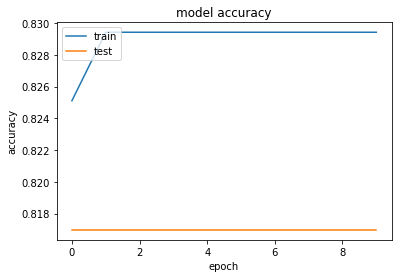

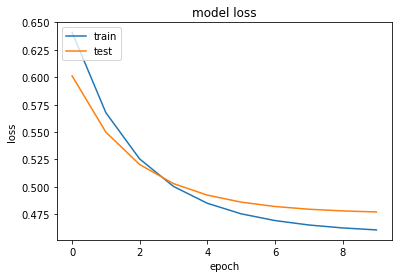

In [12]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()